In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import random
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Sequential
from tensorflow import keras

In [2]:
# All mfcc data are contained in numpy_datas, which is a list. 
# The each entry of the list is another list consistes of [mfccs, file name]
MFCCs_DATA = "MFCCsData"
numpy_datas = []

dirlist = os.listdir(MFCCs_DATA)
for d in dirlist:
    d = os.path.join(MFCCs_DATA, d)
    datalist = os.listdir(d)
    datalist = [[np.load(os.path.join(d,x)), os.path.join(d,x)] for x in datalist]
    numpy_datas.extend(datalist)

In [3]:
# find the max size of mfcc and use it to reshape all mfccs into the same shape
mfcc_size = []
for i in range(len(numpy_datas)):
    mfcc_size.append(numpy_datas[i][0].shape[1])
max(mfcc_size)

1117

In [4]:
# resize into (19,1117) and flatten into (19*1117,1)
for i in range(len(numpy_datas)):
    numpy_datas[i][0] = np.resize(np.resize(numpy_datas[i][0], (19,1117)), (19*1117,1))

In [5]:
# change file name to correct label
angry = []
happy = []
normal = []

for i in range(len(numpy_datas)):
    file_name = numpy_datas[i][1]
    if "angry" in file_name:
        numpy_datas[i][1] = np.array([1,0,0])
        angry.append(numpy_datas[i])
    elif "happy" in file_name:
        numpy_datas[i][1] = np.array([0,1,0])
        happy.append(numpy_datas[i])
    else:
        numpy_datas[i][1] = np.array([0,0,1])
        normal.append(numpy_datas[i])

In [6]:
# first shuffle the list of each emotion
random.shuffle(angry)
random.shuffle(happy)
random.shuffle(normal)

In [7]:
# then select the first 180 in each emotion as train data, first 60 in each emotion as valid data, and first 60 in each emotion as test data
train_data = angry[:int(len(angry)*0.6)] + happy[:int(len(happy)*0.6)] + normal[:int(len(normal)*0.6)]
valid_data = angry[int(len(angry)*0.6):int(len(angry)*(0.6+0.2))] + happy[int(len(happy)*0.6):int(len(happy)*(0.6+0.2))] + normal[int(len(normal)*0.6):int(len(normal)*(0.6+0.2))]
test_data = angry[int(len(angry)*(0.6+0.2)):] + happy[int(len(happy)*(0.6+0.2)):] + normal[int(len(normal)*(0.6+0.2)):]
random.shuffle(train_data)
random.shuffle(valid_data)
random.shuffle(test_data)

In [8]:
# train, valid, test data are all in list consistes of [mfccs, file name]
# want to change the list to two outputs:
# X: vector of mfccs
# Y: vector of labels
def data2vector(data):
    X = []
    Y = []
    for i in range(len(data)):
        X.append(data[i][0])
        Y.append(data[i][1])
    X = np.array(X)
    Y = np.array(Y)
    return X,Y

In [9]:
X_train, Y_train = data2vector(train_data)
X_valid, Y_valid = data2vector(valid_data)
X_test, Y_test = data2vector(test_data)

# calcualte mean and standard deviation
X_train_miu = np.average(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

# normalization
X_train_norm = (X_train - X_train_miu)/X_train_std
X_valid_norm = (X_valid - X_train_miu)/X_train_std
X_test_norm = (X_test - X_train_miu)/X_train_std

In [10]:
# convert array to tensor
X_train_norm = tf.convert_to_tensor(X_train_norm)
X_valid_norm = tf.convert_to_tensor(X_valid_norm)
X_test_norm = tf.convert_to_tensor(X_test_norm)
Y_train = tf.convert_to_tensor(Y_train)
Y_valid = tf.convert_to_tensor(Y_valid)
Y_test = tf.convert_to_tensor(Y_test)

Now we build a 3 layer neuronetwork: linear -> leakyrelu -> linear -> leakyrelu -> linear -> softmax

In [33]:
dnn_model = Sequential()
dnn_model.add(tfl.Dense(16, input_shape=(1117*19,),
                        kernel_initializer='he_normal', bias_initializer='zeros', 
                        activity_regularizer=tf.keras.regularizers.L2(0.2)
                       )
             )
dnn_model.add(tfl.LeakyReLU(alpha=0.05))
dnn_model.add(tfl.Dense(8, 
                        kernel_initializer='he_normal', bias_initializer='zeros', 
                        activity_regularizer=tf.keras.regularizers.L2(0.2)
                       )
             )
dnn_model.add(tfl.LeakyReLU(alpha=0.05))
dnn_model.add(tfl.Dense(3,
                        kernel_initializer='glorot_normal', bias_initializer='zeros',
                        activity_regularizer=tf.keras.regularizers.L2(0.2)
                       )
             )

In [34]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
dnn_model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
dnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16)                339584    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 8)                 136       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 8)                 0         
                                                                 
 dense_20 (Dense)            (None, 3)                 27        
                                                                 
Total params: 339,747
Trainable params: 339,747
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = dnn_model.fit(X_train_norm, Y_train, epochs=100, validation_data=(X_valid_norm, Y_valid))

Epoch 1/100
17/17 [==============================] - 1s 55ms/step - loss: 13.3339 - accuracy: 0.3333 - val_loss: 12.5935 - val_accuracy: 0.3167
Epoch 2/100
17/17 [==============================] - 1s 52ms/step - loss: 9.4256 - accuracy: 0.4000 - val_loss: 11.4035 - val_accuracy: 0.2833
Epoch 3/100
17/17 [==============================] - 1s 49ms/step - loss: 7.9435 - accuracy: 0.4444 - val_loss: 10.3808 - val_accuracy: 0.3111
Epoch 4/100
17/17 [==============================] - 1s 33ms/step - loss: 7.5314 - accuracy: 0.4907 - val_loss: 11.4221 - val_accuracy: 0.3111
Epoch 5/100
17/17 [==============================] - 1s 33ms/step - loss: 8.0671 - accuracy: 0.4370 - val_loss: 11.6544 - val_accuracy: 0.3389
Epoch 6/100
17/17 [==============================] - 0s 21ms/step - loss: 7.8978 - accuracy: 0.4611 - val_loss: 11.3500 - val_accuracy: 0.3278
Epoch 7/100
17/17 [==============================] - 1s 36ms/step - loss: 7.1336 - accuracy: 0.4722 - val_loss: 11.6190 - val_accuracy: 0.350

Epoch 58/100
17/17 [==============================] - 1s 33ms/step - loss: 11.4631 - accuracy: 0.5444 - val_loss: 12.8795 - val_accuracy: 0.3333
Epoch 59/100
17/17 [==============================] - 1s 33ms/step - loss: 11.9765 - accuracy: 0.5019 - val_loss: 12.7718 - val_accuracy: 0.3333
Epoch 60/100
17/17 [==============================] - 1s 32ms/step - loss: 12.5338 - accuracy: 0.4630 - val_loss: 13.5053 - val_accuracy: 0.3278
Epoch 61/100
17/17 [==============================] - 0s 29ms/step - loss: 13.2883 - accuracy: 0.4944 - val_loss: 13.5636 - val_accuracy: 0.3278
Epoch 62/100
17/17 [==============================] - 1s 34ms/step - loss: 11.6344 - accuracy: 0.5481 - val_loss: 11.9335 - val_accuracy: 0.3389
Epoch 63/100
17/17 [==============================] - 0s 25ms/step - loss: 11.2577 - accuracy: 0.5204 - val_loss: 14.4736 - val_accuracy: 0.3611
Epoch 64/100
17/17 [==============================] - 0s 29ms/step - loss: 13.0628 - accuracy: 0.4944 - val_loss: 13.5134 - val_ac

C:\Users\zhuq6\AppData\Local\Temp\ipykernel_30488\903421272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\zhuq6\AppData\Local\Temp\ipykernel_30488\903421272.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

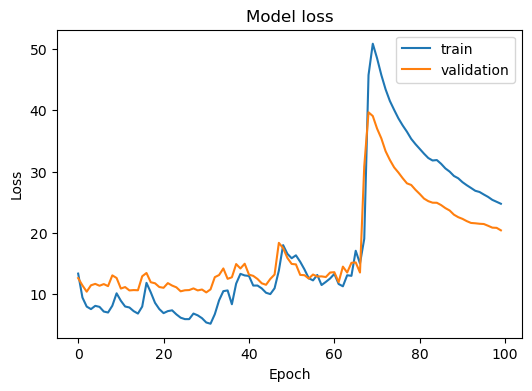

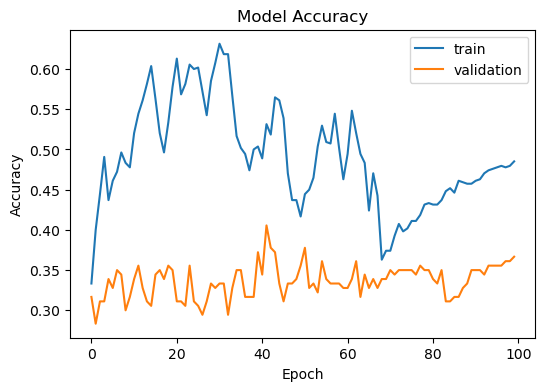

In [36]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')